In [5]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

The above is a function to format .tgz data into csv data

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Load data with pandas and return a Data Frame Object

In [7]:
#See first five rows
#fetch_housing_data() called
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Below split the data into train and test data.

In [12]:
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

#print length of train and test set to be sure the algorithm worked
print(len(train_set))
print(len(test_set))


16512
4128


The above function will change the train and test sets every time you run it,
to be sure that data isn't seen twice, use this function as a hash check.

In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

#Since the dataset does not have an identifier column,
#the solution now would be to use the row index as the ID
housing_with_id = housing.reset_index() #adds index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

#If rows might get deleted, use stable features that won't change 
#to create the ids, like the latitude and longitude since they 
#won't change for a few million years.
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

These are all dandy but Scikit-Learn provides a package to split train set and test set.

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In some scenario, median income is a great tell for predicting median housing prices, to categorize the values of the median incomes, by organizing 5 groups. Since the income is based on thousands of dollars, the intervals at which to show the data will be 0 to 1.5, 1.5 to 3, and so on (where 1.5 signifies $15,000).

<AxesSubplot:>

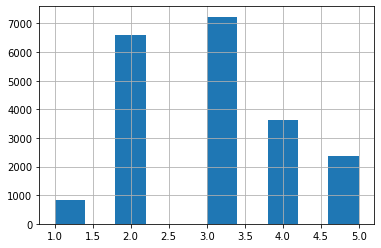

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

From this, we can now do stratified sampling based on the income category.

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#remove income_cat attribute so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


Now time to visualize the data, make a copy of the training set to play with it. Use the training set because that is the data set which the model will be trained after.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

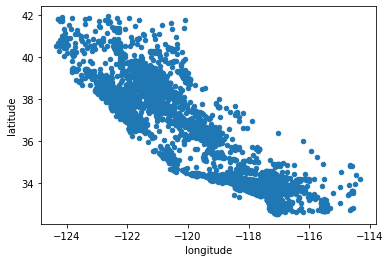

In [16]:
housing_train = strat_train_set.copy()

housing_train.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

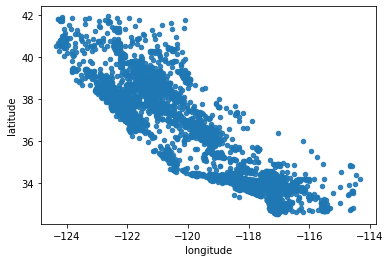

In [18]:
#Set alpha value to 0.1 to see the highest areas of density
housing_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

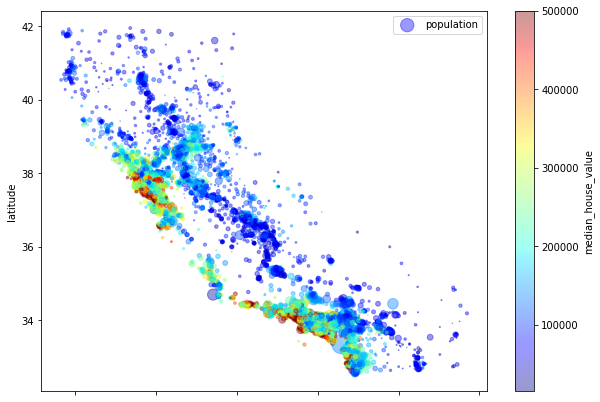

In [19]:
import matplotlib.pyplot as plt
#Represent values for housing prices with different colors, blue being low and red being high
housing_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing_train["population"]/100, label="population", figsize=(10,7), 
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
)
plt.legend()


Now it's time to look for correlations, using 